In [1]:
# For passwords & database access:
import psycopg2
import psycopg2.extras
import getpass

# For plotting
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display
import ipywidgets

# For math
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import pandas as pd
import shapely.wkt as wkt
from shapely.geometry import Point

In [2]:
# Logging in
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")
db = psycopg2.connect( f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'" )

db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

DB User:  kennedyt
DB Password:  ············


#### Choices (uncomment one field and one filename):

In [3]:
# field = "COSMOS"
# fnm = "./COSMOS_result.txt" # Use all known AGN in COSMOS
# fnm = "./COSMOS2015_result.txt" # Use AGN from COSMOS2015 catalog
# fnm = "./ACS-GC_result.txt" # Use AGN from ACS-GC catalog

# field = "ELAIS"
# fnm = "./ELAIS_result.txt" # All ELAIS AGN
# fnm = "./ESIS_result.txt" # Use AGN from ESIS (ESO-Spitzer Imaging extragalactic Survey)
# fnm = "./SWIRE_result.txt" # Use AGN from SWIRE

# Doesn't matter a ton, makes the polygons more tight if it's smaller, but runs slower, I recommend 0.05
prec=0.05 

#### Making a simple polygon enclosing our field (short enough that its vertices fit in an ADQL query)

In [4]:
### Pull all cand ras+decs:
if field=="COSMOS":
    query = ("SELECT c.ra, c.dec FROM candidates c "
             "JOIN objects o ON o.candidate_id=c.id "
             "JOIN subtractions s ON s.id=o.subtraction_id "
             "JOIN exposures e ON e.id = s.exposure_id "
             "WHERE (e.proposalid = '2021A-0113' "
             "OR e.proposalid = '2021B-0149' )"
             "AND c.dec > 0 " # COSMOS
             "LIMIT 10000000")
elif field=="ELAIS":
    query = ("SELECT c.ra, c.dec FROM candidates c "
             "JOIN objects o ON o.candidate_id=c.id "
             "JOIN subtractions s ON s.id=o.subtraction_id "
             "JOIN exposures e ON e.id = s.exposure_id "
             "WHERE (e.proposalid = '2021A-0113' "
             "OR e.proposalid = '2021B-0149' )"
             "AND c.ra < 50 " # ELAIS
             "LIMIT 10000000")
cursor.execute( query, )

radecquery = np.array(cursor.fetchall()).transpose().astype(float)
radecquery = np.unique(radecquery.transpose(), axis=0).transpose()

In [5]:
### Create a polygon object using all of those points as vertices
polystr = str([str(i[0])+" "+str(i[1]) for i in np.round(radecquery.T,2)]).replace("'","")
if field=="COSMOS":
    pol = wkt.loads("POLYGON (({}))".format(polystr[1:-1]+', '+polystr[1:12])) # COSMOS
elif field=="ELAIS":
    pol = wkt.loads("POLYGON (({}))".format(polystr[1:-1]+', '+polystr[1:11])) # ELAIS

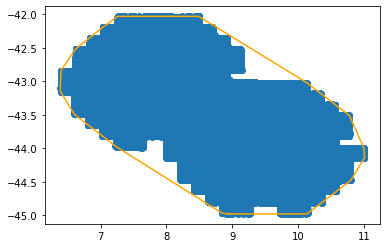

In [6]:
### Simplify the polygon to the simplest convex shape that encloses all data:
polconvhull = pol.convex_hull
convhullarr = polconvhull.exterior.coords.xy

plt.scatter(*radecquery)
plt.plot(convhullarr[0],convhullarr[1],color='orange') # orange is simplest convex polygon enclosing all pts

In [7]:
### Grabbed every AGN within that orange boundary from SIMBAD at http://simbad.u-strasbg.fr/simbad/sim-tap
### Used this query, saved as {field}_result.txt in this directory
### Just showing my work, the query results for all of the below are saved to this directory already
print("SELECT distinct main_id, ra, dec, otype_txt")
print("FROM basic")
print("WHERE otype = 'AGN..'") # 'AGN..' here means all subtypes of AGN (QSOs, seyferts, etc.)
print("AND CONTAINS(POINT('ICRS', ra, dec), POLYGON('ICRS', {})) = 1".format(str(list(np.array(convhullarr).T.flatten()))[1:-1]))
print("GROUP BY main_id, otype_txt, ra, dec")

### SIMBAD ADQL queries used for the catalog-specific queries

# print("""
# SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
# FROM basic
# JOIN IDENT on IDENT.oidref=basic.oid
# WHERE basic.otype = 'AGN..'
# AND IDENT.id like 'ESIS%'
# AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', {})) = 1
# GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec
# """.format(str(list(np.array(convhullarr).T.flatten()))[1:-1]))

# """
# SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
# FROM basic
# JOIN IDENT on IDENT.oidref=basic.oid
# WHERE basic.otype = 'AGN..'
# AND IDENT.id like 'COSMOS2015%'
# AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', 148.76, 0.77, 148.3, 1.26, 148.14, 1.6, 148.14, 1.91, 148.3, 2.23, 149.07, 3.57, 149.23, 3.75, 149.38, 3.91, 149.54, 4.08, 150.46, 4.08, 150.62, 3.91, 150.77, 3.75, 150.93, 3.57, 151.71, 2.23, 151.86, 1.73, 151.86, 1.59, 151.71, 1.26, 151.24, 0.77, 148.76, 0.77)) = 1
# GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec
# """

# """
# SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
# FROM basic
# JOIN IDENT on IDENT.oidref=basic.oid
# WHERE basic.otype = 'AGN..'
# AND IDENT.id like 'ACS-GC%'
# AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', 148.76, 0.77, 148.3, 1.26, 148.14, 1.6, 148.14, 1.91, 148.3, 2.23, 149.07, 3.57, 149.23, 3.75, 149.38, 3.91, 149.54, 4.08, 150.46, 4.08, 150.62, 3.91, 150.77, 3.75, 150.93, 3.57, 151.71, 2.23, 151.86, 1.73, 151.86, 1.59, 151.71, 1.26, 151.24, 0.77, 148.76, 0.77)) = 1
# GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec
# """;

SELECT distinct main_id, ra, dec, otype_txt
FROM basic
WHERE otype = 'AGN..'
AND CONTAINS(POINT('ICRS', ra, dec), POLYGON('ICRS', 8.95, -44.98, 8.85, -44.97, 7.23, -43.97, 7.02, -43.81, 6.6, -43.49, 6.39, -43.15, 6.39, -43.07, 6.4, -42.84, 6.62, -42.52, 7.04, -42.19, 7.26, -42.03, 8.49, -42.03, 10.13, -43.02, 10.78, -43.51, 11.0, -44.0, 11.01, -44.11, 11.01, -44.14, 10.8, -44.48, 10.15, -44.97, 10.13, -44.98, 8.95, -44.98)) = 1
GROUP BY main_id, otype_txt, ra, dec


In [8]:
agn = np.loadtxt(fnm, skiprows=2,delimiter='|', dtype=str) # Reding in SIMBAD data
agnnames, agnras, agndecs, agntypes = agn.T
agnras, agndecs = agnras.astype(float), agndecs.astype(float)
agncoords = np.array([agnras,agndecs]).T

In [9]:
### Now have coords for every agn in the orange boundary (this includes things outside our fields still)
agncoords[:5]

array([[  8.45583333, -43.38527778],
       [  8.35625   , -43.36916667],
       [  8.47333333, -43.35777778],
       [  8.29208333, -43.35138889],
       [  8.46208333, -43.35222222]])

#### This section draws a tighter polygon around the field and excludes SIMBAD AGN from outside that region

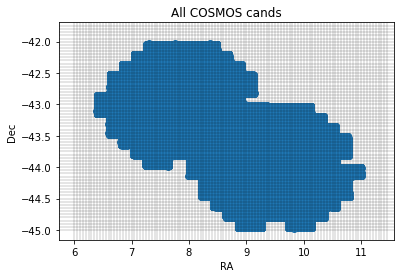

In [10]:
### Create a stricter boundary now that we have the raw data:
### I do this by making a grid and labelling each rectangle as 'containing data' or not 
### (if I don't condense the data like this, making the polygon gets computationally prohibitive)

plt.scatter(radecquery[0],radecquery[1])
plt.title("All COSMOS cands")
plt.xlabel("RA")
plt.ylabel("Dec")

if field=="ELAIS":
    ys = np.arange(-45.0,-41.7,prec) # ELAIS
    xs = np.arange(6,11.5,prec) # ELAIS
    xys = np.meshgrid(xs,ys) # ELAIS
elif field=="COSMOS":
    ys = np.arange(0.65,4.25,prec) # COSMOS
    xs = np.arange(148,152,prec) # COSMOS
    xys = np.meshgrid(xs,ys) # COSMOS

for i in ys:
    plt.axhline(i, color='black',lw=0.2)
for i in xs:
    plt.axvline(i, color='black',lw=0.2)

In [11]:
good = []
for i in range(len(xs)):
    for j in range(len(ys)):
        data = radecquery[0][np.where((radecquery[0]<xs[i]+prec) & (radecquery[0]>xs[i]) \
                                      & (radecquery[1]<ys[j]+prec) & (radecquery[1]>ys[j]))[0]]
        if len(data) > 0:
            good.append([i,j])
goodidx = np.array(good).transpose()
goodxs = xs[goodidx[0]] + prec/2 # Center coordinate within grid box
goodys = ys[goodidx[1]] + prec/2 # Center coordinate within grid box
goods = np.array([goodxs,goodys])

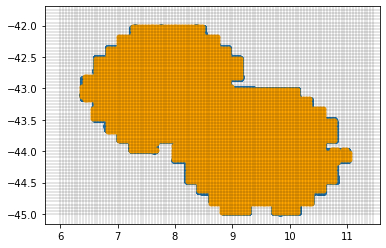

In [31]:
plt.scatter(*radecquery)
plt.scatter(*goods,lw=0.05, color='orange')
for i in ys:
    plt.axhline(i, color='black',lw=0.2)
for i in xs:
    plt.axvline(i, color='black',lw=0.2)

In [32]:
pol2str = str([str(i[0])+" "+str(i[1]) for i in np.round(goods.T,2)]).replace("'","")

if field=="COSMOS":
    pol2 = wkt.loads("POLYGON (({}))".format(pol2str[1:-1]+', '+pol2str[1:12])) # COSMOS
elif field=="ELAIS":
    pol2 = wkt.loads("POLYGON (({}))".format(pol2str[1:-1]+', '+pol2str[1:12])) # ELAIS

pol3 = pol2.buffer(prec)
pol3arr = pol3.exterior.coords.xy

In [33]:
agnmsk = []
for coord in agncoords:
    pt = Point(coord[0],coord[1])
    agnmsk.append(pt.within(pol3))
agncoords1 = agncoords[agnmsk]
agnnames1 = agnnames[agnmsk]
agntypes1 = agntypes[agnmsk]

In [34]:
len(agncoords), len(agncoords1)

(346, 346)

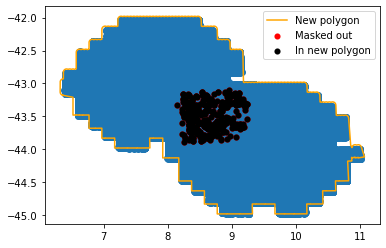

In [38]:
plt.scatter(*radecquery)
plt.plot(*pol3arr, color='orange',label="New polygon")
plt.scatter(*agncoords.T,color='red', lw=0.1, label="Masked out")
plt.scatter(*agncoords1.T,color='black', lw=0.1, label="In new polygon")
# plt.scatter(agncoords.T[0][np.char.startswith(agnnames,'"SWIR')],agncoords.T[1][np.char.startswith(agnnames,'"SWIR')], color="g")
plt.legend(loc='upper right')

#### So now we have all of the known AGN we could theoretically detect in our field
Next step is to match them up to "probably-real" candidates

In [17]:
### Grab all cand names for 'probably-real' cands
realcandsarr = np.genfromtxt('../../candidate_nightly_epochs_files/candidate_lightcurve_parameters.dat', dtype=str)
realcands = np.unique(realcandsarr.T[1])

In [18]:
### Find coords and make SkyCoord objects for all candidates:
candcoord = []
for i in realcands:
    query = ("SELECT c.ra, c.dec FROM candidates c "
             "WHERE c.id = %s "
             "LIMIT 1")
    cursor.execute(query,(i,))
    res = np.array(cursor.fetchall())[0]
    candcoord.append([i,res])
candcoord1 = np.array([[i[0], SkyCoord(i[1][0],i[1][1], unit='deg')] for i in candcoord])

In [19]:
### Make a catalog-style set of SkyCoords for the SIMBAD sample
agncoords2 = SkyCoord(agncoords1,unit='deg')

In [20]:
### Match the datasets with a 2 arcsec radius
matches = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(agncoords2)
    if sep2d < 2*u.arcsec:
        matches.append([i,coord,idx, sep2d])
matches = np.array(matches)

/tmp/ipykernel_5570/2178453017.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  matches = np.array(matches)


In [24]:
### Display percentages matched
matchmsk = matches.T[2].astype(int)
agncoordsmatched = agncoords1[matchmsk]
agntypesmatched = agntypes1[matchmsk]
agnnamesmatched = agnnames1[matchmsk]
print("For the {} field:".format(field))
print("Using this file: {}".format(fnm))
for typee in np.unique(agntypes):
    msk = np.where(agntypesmatched==typee)[0]
    nummatched = len(agnnamesmatched[msk])
    try:
        numtot = len(agnnames1[agntypes1==typee])
        perc = np.round(nummatched/numtot*100,2)
        print("found {} out of {} {} ({} %)".format(nummatched, numtot,typee,perc))
    except:
        pass
print("We detected {} known agn as 'probably-real' candidates, out of {} known agn".format(len(matches), len(agncoords1)))
print("This represents {} % of all the known agn in our field".format(np.round(len(matches)/len(agncoords1)*100,2)))

For the ELAIS field:
Using this file: ./ESIS_result.txt
found 28 out of 316 "AGN"     (8.86 %)
found 0 out of 3 "LIN"     (0.0 %)
found 3 out of 24 "QSO"     (12.5 %)
found 0 out of 2 "Sy1"     (0.0 %)
found 0 out of 1 "Sy2"     (0.0 %)
We detected 31 known agn as 'probably-real' candidates, out of 346 known agn
This represents 8.96 % of all the known agn in our field
